In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
np.random.seed(42)

## Week 13: From Notebooks to the Web: Github Pages, Web Servers, and Dash
November 26, 2019

## Housekeeping

- Assigment #7 (including final project proposal) due by Friday at 5pm
- Grading for assignments #5 and #6 should be done soon — solutions have been uploaded
- There will be additional office hours the week of Dec 9th (the week after classes end)
    - Will setup survey to find the best time
    
**Final project due: 5pm on Monday, December 16th**

## Outline for the next two weeks

We'll spend the next two weeks discussing ways to translate our analysis results to the Web in a meaningful way. We'll cover three methods to do so, each with their own pros and cons:

1. Embedding interactive charts on the Web via Github Pages
1. Creating Web apps & dashboards using the Python library [Dash](https://dash.plot.ly/)
1. Creating Web apps & dashboards using the Python library [Panel](https://panel.pyviz.org/)

**Today: we'll focus on the first two today and cover Panel in detail in next week's lecture.**

## Part 1: Embedding Interactive Charts on the Web

To start, let's recap three ways that we've learned to produce interactive charts in the course:

- Altair
- Hvplot
- Folium

## Example 1: Measles Incidence in Altair

Load the data from week 2:

In [2]:
url = "https://raw.githubusercontent.com/MUSA-620-Fall-2019/week-2/master/data/measles_incidence.csv"
data = pd.read_csv(url, skiprows=2, na_values='-')

In [3]:
data.head()

,YEAR,WEEK,ALABAMA,ALASKA,ARIZONA,ARKANSAS,CALIFORNIA,COLORADO,CONNECTICUT,DELAWARE,...,SOUTH DAKOTA,TENNESSEE,TEXAS,UTAH,VERMONT,VIRGINIA,WASHINGTON,WEST VIRGINIA,WISCONSIN,WYOMING
0,1928,1,3.67,NaN,1.90,4.11,1.38,8.38,4.50,8.58,...,5.69,22.03,1.18,0.4,0.28,NaN,14.83,3.36,1.54,0.91
1,1928,2,6.25,NaN,6.40,9.91,1.80,6.02,9.00,7.30,...,6.57,16.96,0.63,NaN,0.56,NaN,17.34,4.19,0.96,NaN
2,1928,3,7.95,NaN,4.50,11.15,1.31,2.86,8.81,15.88,...,2.04,24.66,0.62,0.2,1.12,NaN,15.67,4.19,4.79,1.36
3,1928,4,12.58,NaN,1.90,13.75,1.87,13.71,10.40,4.29,...,2.19,18.86,0.37,0.2,6.70,NaN,12.77,4.66,1.64,3.64
4,1928,5,8.03,NaN,0.47,20.79,2.38,5.13,16.80,5.58,...,3.94,20.05,1.57,0.4,6.70,NaN,18.83,7.37,2.91,0.91


Use the `pandas.melt()` function to convert it to tidy format:

In [4]:
annual = data.drop('WEEK', axis=1)
measles = annual.groupby('YEAR').sum().reset_index()
measles = measles.melt(id_vars='YEAR', var_name='state', value_name='incidence')

In [5]:
measles.head()

,YEAR,state,incidence
0,1928,ALABAMA,334.99
1,1929,ALABAMA,111.93
2,1930,ALABAMA,157.00
3,1931,ALABAMA,337.29
4,1932,ALABAMA,10.21


Now let's load altair:

In [6]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

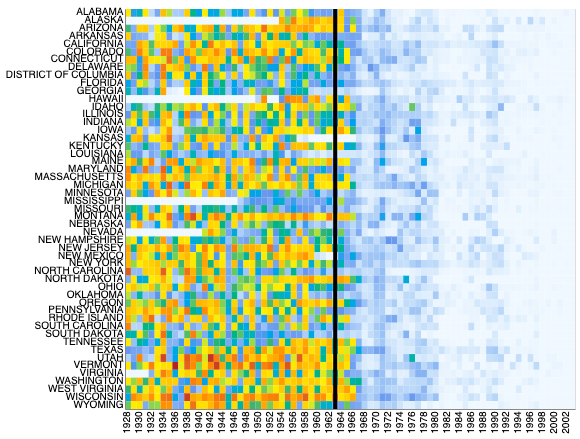

In [7]:
# use a custom color map
colormap = alt.Scale(
    domain=[0, 100, 200, 300, 1000, 3000],
    range=[
        "#F0F8FF",
        "cornflowerblue",
        "mediumseagreen",
        "#FFEE00",
        "darkorange",
        "firebrick",
    ],
    type="sqrt",
)

# Vertical line for vaccination year
threshold = pd.DataFrame([{"threshold": 1963}])

# plot YEAR vs state, colored by incidence
chart = (
    alt.Chart(measles)
    .mark_rect()
    .encode(
        x=alt.X("YEAR:O", axis=alt.Axis(title=None, ticks=False)),
        y=alt.Y("state:N", axis=alt.Axis(title=None, ticks=False)),
        color=alt.Color("incidence:Q", sort="ascending", scale=colormap, legend=None),
        tooltip=["state", "YEAR", "incidence"],
    )
    .properties(width=450, height=400)
)

rule = alt.Chart(threshold).mark_rule(strokeWidth=4).encode(x="threshold:O")

out = chart + rule
out

### Saving Altair Plots

Altair plots can be fully represented as JSON data. This makes them very easy to embed on websites, as we shall soon see!

In [8]:
# save the chart as JSON
out.save("measlesAltair.json") 

In [9]:
# save the chart as HTML
out.save("measlesAltair.html")

Now, let's compare the HTML and JSON files...

## Measles Incidence in hvplot

In [12]:
import hvplot.pandas
import hvplot

In [13]:
# Make the heatmap with hvplot
heatmap = measles.hvplot.heatmap(
    x="YEAR",
    y="state",
    C="incidence", # color each square by the incidence
    reduce_function=np.sum, # sum the incidence for each state/year
    frame_height=400,
    frame_width=500,
    flip_yaxis=True,
    rot=90,
    colorbar=False,
    cmap="viridis",
    xlabel="",
    ylabel="",
)

# Some additional formatting using holoviews 
# For more info: http://holoviews.org/user_guide/Customizing_Plots.html
heatmap = heatmap.redim(state="State", YEAR="Year")
heatmap = heatmap.opts(fontsize={"xticks": 0, "yticks": 6}, toolbar="above")
heatmap

:HeatMap   [Year,State]   (incidence)

### Saving Hvplot Plots

HTML is are only option here...

In [14]:
import hvplot

In [15]:
hvplot.save(heatmap, 'measlesHvplot.html')

## Example 3: Folium + OSMnx

- This is a recap of the material we covered in Week 9. 
- We'll quickly walk through how we used osmnx to created an interactive Folium map of the shortest route between two points.

First, load Zillow neighborhoods using esri2gpd:

In [16]:
import esri2gpd

In [17]:
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Philly_Neighborhoods/FeatureServer/0"
zillow = esri2gpd.get(url, fields=["MAPNAME"]).rename(
    columns={"MAPNAME": "neighborhood"}
)

In [18]:
zillow.head()

,geometry,neighborhood
0,"POLYGON ((-75.06773 40.00541, -75.06834 40.006...",Bridesburg
1,"POLYGON ((-75.01560 40.09488, -75.01827 40.097...",Bustleton
2,"POLYGON ((-75.18848 40.07274, -75.18811 40.072...",Cedarbrook
3,"POLYGON ((-75.21221 40.08604, -75.21230 40.086...",Chestnut Hill
4,"POLYGON ((-75.18479 40.02838, -75.18548 40.028...",East Falls


Trim to only the Northern Liberties + Fishtown neighborhoods:

In [19]:
sel = zillow['neighborhood'].isin(['Fishtown - Lower Kensington', 'Northern Liberties'])
zillow = zillow.loc[sel]

Take the unary union to get the outer boundary of both neighborhoods:

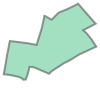

In [20]:
nolibs_fishtown = zillow.geometry.unary_union
nolibs_fishtown

Use osmnx to get the street network graph within the Northern Liberties / Fishtown boundary:

In [21]:
import osmnx as ox

In [22]:
# get the graph
G_nolibs_fishtown = ox.graph_from_polygon(nolibs_fishtown, 
                                          network_type='drive')

Find the nearest nodes (intersections) in the street network near Frankford Hall and Spring Garden Station:

In [23]:
# two points in Northern Liberties / Fishtown
spring_garden_station = (39.960421, -75.140340)
frankford_hall = (39.969381, -75.134599)

# get the nearest network node to each point
orig_node = ox.get_nearest_node(G_nolibs_fishtown, spring_garden_station)
dest_node = ox.get_nearest_node(G_nolibs_fishtown, frankford_hall)

Use networkx to calculate the shortest path:

In [24]:
import networkx as nx

In [25]:
# get the shortest path --> just a list of node IDs
route = nx.shortest_path(G_nolibs_fishtown, 
                         orig_node, dest_node, 
                         weight='length')

Generate the Folium interactive map using osmnx:

In [26]:
# The interactive map of the street network
graph_map = ox.plot_graph_folium(G_nolibs_fishtown, popup_attribute="name", edge_width=2)

# The interactive map of the route, with the streets in the background
route_graph_map = ox.plot_route_folium(G_nolibs_fishtown, route, route_map=graph_map)

# This is just a Folium map
type(route_graph_map)

folium.folium.Map

### Saving Folium Maps

Just use the `save()` function!

In [27]:
route_graph_map.save("foliumChart.html")

## How can we display these charts on the Web? 

We can **embed** them on GitHub Pages...

## Part 2: Github Pages

- We can embed these interactive charts on static (no server) websites such as Github Pages
- Github Pages is static website that can be automatically generated from *any* Github repository

## Template Site with Examples

- I've created a *template repository* that you can use to quickly get up and running with Github Pages
- Available at: https://github.com/MUSA-620-Fall-2019/github-pages-starter
- The rendered site is available at: https://musa-620-fall-2019.github.io/github-pages-starter

## Github Pages URL

The structure of the URL for the rendered page is:

`https://[USERNAME].github.io/[REPOSITORY NAME]`

**Note:** you can create a new website for every repository, so this will work even if you have a personal Github Pages website set up.

### Step 1: Create your own repository

- The main repository at https://github.com/MUSA-620-Fall-2019/github-pages-starter is a *template repository*
- Click on the "Use this template" button to create your own version of the repository

<img src="./imgs/gh-pages-fork.png" width=700>

For more information, see [this guide on creating a repository from a template](https://help.github.com/en/github/creating-cloning-and-archiving-repositories/creating-a-repository-from-a-template).

### Step 2: Choose a name and description

<img src="./imgs/gh-pages-fork-2.png" width=700>

### Step 3: Enable Github Pages on your new repository

On the home page for your new repository go to "Settings":

<img src="./imgs/gh-pages-settings-1.png" width=700>

- Scroll down, and under the "Github Pages" section, select the "Master" as the branch to be used for GitHub pages. 
- This will automatically build the website at the following URL: `https://[USERNAME].github.io/[REPOSITORY NAME]`

<img src="./imgs/gh-pages-settings-2.png" width=700>

### Step 4: Customize your site

- Enter your site name, description, etc by editing the [`_config.yml`](https://github.com/MUSA-620-Fall-2019/github-pages-starter/blob/master/_config.yml) file.
- There are 3 different ways that you can make changes to your blog's files:
    - Edit files within your in the browser at GitHub.com
    - Use a third party GitHub content editor, like [Prose by Development Seed](http://prose.io).
    - Clone down your repository and make updates locally, then push them to your GitHub repository.
  

For more information on the config file, see the [documentation](https://mmistakes.github.io/minimal-mistakes/docs/configuration/).

### Step 5: Publish a post

- Posts are written in Markdown and any files added to the `_posts` directory will be automatically uploaded and published
- Useful resource: [Markdown Cheatsheet](http://www.jekyllnow.com/Markdown-Style-Guide/)

## Adding new posts

To add new posts, simply add a file in the `_posts` directory that:

1. follows the convention `YYYY-MM-DD-name-of-post.ext`
1. Includes the necessary header material (see the next slide) 

You can take a look at the source for the existing posts in the `_posts` folder to get an idea about how it works.

## The anatomy of a post

<img src="./imgs/posts-example-1.png" width=700>

- Source: https://raw.githubusercontent.com/MUSA-620-Fall-2019/github-pages-starter/master/_posts/2019-04-17-example-post.md
- Rendered: https://musa-620-fall-2019.github.io/github-pages-starter/example-post/

## How can we embed our (static) Matplotlib charts?

These are just normal PNG images — we can use Markdown's syntax for embedding images.



<img src="./imgs/gh-pages-matplotlib.png" width=700>


## Embedding images: the syntax

`![alt-text]({{ site.url }}{{ site.baseurl }}/assets/images/YOUR_IMAGE_FILE.png`

### Steps

1. Place your image in the `assets/images/` folder
1. Change `YOUR_IMAGE_FILE.png` to the name of your image.


**Note:** the curly brackets for `site.url` and `site.baseurl` are template variables. When the site is rendered, these variables automatically get filled in so that the absolute path to the PNG file is correct.

## How can we embed our interactive charts?

In the *header*, we can specify the charts to load using special loaders, which can handle three different types of files:

- Altair plots via the JSON specification
- Hvplot/Holoviews HTML files
- Folium HTML files

## Embedding Altair/Hvplot charts: example

- Source: https://raw.githubusercontent.com//MUSA-620-Fall-2019/github-pages-starter/blob/master/_posts/2019-04-13-measles-charts.md
- Rendered: https://musa-620-fall-2019.github.io/github-pages-starter/measles-charts/

## Embedding Altair/Hvplot charts: the header

<img src="./imgs/posts-altair-hvplot-1.png" width=700>

## Header syntax

For both the `altair-loader` and `hv-loader`, the syntax is:

**CSS identifier for chart : "chart file path"**

Here, there **must** be a matching "div" element with the same CSS identifier — this is where the chart will be embedded!

## Embedding Altair/Hvplot charts: the content

<img src="./imgs/posts-altair-hvplot-2.png" width=700>

## Embedding Folium charts: example

- Source: https://raw.githubusercontent.com/MUSA-620-Fall-2019/github-pages-starter/blob/master/_posts/2019-04-13-folium-charts.md
- Rendered: https://musa-620-fall-2019.github.io/github-pages-starter/folium-charts/

## Embedding Folium charts: the header

<img src="./imgs/posts-folium-1.png" width=700>

## Header syntax

For the `folium-loader`, the syntax is:

**CSS identifier for chart : ["chart file path", "width of chart in pixels"]**

Again, there **must** be a matching "div" element with the same CSS identifier — this is where the chart will be embedded!

## Embedding Folium charts: the content

<img src="./imgs/posts-folium-2.png" width=700>

## So, which files are important?

There's a lot of extra stuff we don't actually need. The most important files/folders are:

- `_config.yml`: the main configuration file for the site, where you can change names, titles, etc
- `_posts/`: where the markdown posts (your content!) go
- `assets/images/`: where you can place your static matplotlib-generated PNG files
- `charts/`: where you can place your `.html` or `.json` files from Altair/Hvplot/Folium


## Exercise: Setup your own Github Pages project page

**Steps:**
- Follow the above instructions to set up your own project website
- Create an interactive Altair chart for the Gapminder health/income dataset
- Create a new post by adding a new post (with the proper file name convention) to the `_posts` folder
- Embed the Altair chart in your new post

**Notes**
- As a reminder, the gapminder dataset is available from the built-in `vega_datasets` package
- We want to plot a scatter chart with the income on the x-axis and the life expectancy on the y-axis 

In [28]:
import altair as alt
from vega_datasets import data

source = data.gapminder_health_income.url
source

'https://vega.github.io/vega-datasets/data/gapminder-health-income.csv'

## Part 3: Web Servers

A few quick basics before we move on to interactive Web apps with Dash...

## Some (oversimplified) basics

- The browser needs a file -> it requests it via the HTTP protocol
- The web server receives the request, and if the requested file exists, sends it back to the browser using HTTP

<img src="imgs/web-server.png" width=600>

## Two main types:

**Static** and **dynamic**

## Static Web Servers

- Serves hosted HTML files to the browser "as-is"
- Response from the server is always the same — *static*
- Example: Github Pages

## Dynamic Web Servers

- Capable of serving *dynamic* content to browsers
- Extra software that executes *server-side* before sending the response back to the browser
- Common example: querying a database server
    - browser sends request for data with specific query parameters
    - server responds dynamically, sending the requested data

For more information: [Mozilla documentation](https://developer.mozilla.org/en-US/docs/Learn/Common_questions/What_is_a_web_server)

## CARTO: a dynamic web server

<img src="imgs/carto-url.png" width=1200></img>

## Anatomy of a request

- **Base URL**: shown in blue
- **?**: separates the base URL from the query parameters
- **Query parameters**: tells the web server how to respond to the request
- **&**: separator between the query parameters

## Flask: a micro web framework in Python

A very lightweight package for framework for dynamic web apps

[Flask documentation](http://flask.pocoo.org/docs/1.0/)

## Example 1: your first Flask app


- Store the code for our app in a ".py" file: 
- Create a "local" web server by executing our application code locally
- This allows us to build and test our app before deploying the code to a remote web server

## Getting set up

From within the Jupyter notebook interface: 
- Navigate to the "hello-flask" folder
- Click on the "hello.py" file to launch the file editor
- Launch a new terminal window by clicking on "New -> Terminal"

Flask code: [hello.py](https://github.com/MUSA-620-Spring-2019/week-12/blob/master/hello-flask/hello.py)

**Important: this won't work on Binder, it needs to be running on your local machine**

## To start a local server

Run the following commands from the Terminal window in Jupyter notebook:

```bash
cd hello-flask
python3.7 hello.py
```

<img src="imgs/starting-flask.png" width=800>

## The "python3.7" command

- This will execute the `*.py` file
- Only the code below `if __name__ == '__main__':` gets executed

[StackOverflow answer](https://stackoverflow.com/questions/419163/what-does-if-name-main-do) about the if-name-main syntax in Python.

### Note

There are sometimes Anaconda-related issues where "python3.7" will point to the wrong version of Python. You can double check by running:

```
which python3.7
```

This should print out a path name that includes the name of our Python environment (musa-620)

## Take a look at hello.py

<img src="imgs/python-main.py.png" width=600>

## View your application!

Navigate in the browser to: http://0.0.0.0:5000

You should see the text: "Hello, World!"

## Editing your app with a running server

Try editing the `hello.py` file in your editor, saving, and re-loading the application page. You should see the app update to reflect the changes!

## Example 2: using templates

- Flask can load and render HTML files when specific routes are requested by the browser
- Templates should be stored in a `templates/` directory
- The `hello-template.py` app loads the `templates/hello.html` when the `/hello/` route is requested by the browser

Flask code: [hello-template.py](https://github.com/MUSA-620-Spring-2019/week-12/blob/master/hello-flask/hello-template.py)

## From the terminal window

```bash
python3.7 hello-template.py
```

The main page ("/") renders the same thing as the previous app ("Hello, World!").

**Navigate to the "/hello/" route and you should see:**

<img src="imgs/flask-template.png" width=600>

## Example 3: setting up an API with request parameters

`hello-api.py`: a more sophisticated example using *request parameters**

Run: 

```bash
python3.7 hello-api.py
```

Flask code: [hello-api.py](https://github.com/MUSA-620-Spring-2019/week-12/blob/master/hello-flask/hello-api.py)

## Navigate to the "/shootings" route

This uses default request parameters: days = 90 and fatal = 0

<img src="imgs/flask-shootings.png" width=600>

## Now pass "days" and "fatal" parameters

This returns the number of fatal/nonfatal shootings in the past X "days"

<img src="imgs/flask-shootings-2.png" width=700>

## Getting closer to a more realistic use case...

**Steps:**
1. Get request parameters from the browser (input by the user)
1. Query CARTO database for data based on that input
1. Perform an operation on that data (in this case, count number of shootings)
1. Return computed result back to the browser

## Note: If you receive a "OSError: Address already in use"

- If you encounter the "Address already in use" error, you are trying to run multiple Flask servers on the same port
- The port is the number after the address; e.g., for http://0.0.0.0:5000/, the port is 5000
- The easiest solution: run Ctrl-C to end all of the Flask servers but one, or change the `port=5000` keyword when initialize the app in the Python script



## Now, that we have the basics on to a more advanced library...

## Part 4: Dash


The result of Python programmers asking the question: **can we build a dashboard just in Python?**

The answer is yes...for the most part.

You still need to use *some* CSS styling and know about different HTML elements. But everything is coded in Python.

## Dash

- Built on Flask, similar web framework setup
- Construct Python wrappers of common HTML elements, like "div", "p", etc.
- Allows you to define layout of page purely in Python
- Use Python functions to control how browser interacts with the app — just like Flask

## Benefits

- Everything can be done in Python — no more HTML templates
- Use Python to define how user input elements (e.g., sliders) interact with server — no more custom Javascript
- Very sleek, beautiful widgets and interactive components built in to the library
- Can handle Markdown too
- Good tutorials and user guide — https://dash.plot.ly/

## Downsides

- Built to be used with the [Plotly](https://plot.ly/python) visualization library
- Private company that has open-sourced their interactive visualization library
- A bit more work to get non-Plotly visualizations working — need to use our IFrame trick

## The general workflow

In your Python Dash app, there are two main steps:

1. Define the HTML layout, e.g., "div" elements, slider elements, etc. 
1. Define functions that take inputs from the interactive widgets from Step 1. and return the output for other HTML elements. 
    - When the user changes a slider, dropdown, etc, the function will run, and return the updated output

## Dash HTML components = "the app layout"

- Wrappers for all of the common HTML elements
- Stored in the `dash_html_components` module

See: https://dash.plot.ly/dash-html-components

In [2]:
# The standard import
import dash_html_components as html

## Dash HTML Example

```
html.Div([
    html.H1('Hello Dash'),
    html.Div([
        html.P('Dash converts Python classes into HTML'),
        html.P('This conversion happens behind the scenes by Dash's JavaScript front-end')
    ])
])
```

This gets converted automatically to the following HTML in your web app:

```
<div>
    <h1>Hello Dash</h1>
    <div>
        <p>Dash converts Python classes into HTML</p>
        <p>This conversion happens behind the scenes by Dash's JavaScript front-end</p>
    </div>
</div>
```

## Dash core components = "widgets"

- A set of fancy widgets already built in! 
- Stored in the `dash_core_components` module

See: https://dash.plot.ly/dash-core-components

In [1]:
# The standard import for these components
import dash_core_components as dcc

### Note: Markdown is also supported!

Use the `dcc.Markdown()` object to automatically convert Markdown into HTML in your web apps!

## Reference: HTML and CSS tutorials 

The core components and HTML components in Dash remove most of the direct HTML/CSS, but still good to know some of the basics:

- [HTML Tutorial](https://developer.mozilla.org/en-US/docs/Learn/HTML/Introduction_to_HTML)
- [CSS Tutorial](https://developer.mozilla.org/en-US/docs/Learn/CSS/Introduction_to_CSS)

**Useful to keep these references handy if you are unsure about syntax for HTML and/or CSS**

## The Dash Getting Started Guide

https://dash.plot.ly/getting-started

## Combining Dash with Altair and Folium

- You are welcome to incorporate Plotly visualizations directly into your dashboard, but it can get complicated quickly
- I am not a huge fan of Plotly's API and documentation
- Focus on a few examples showing Altair + Dash and Folium + Dash

**Key:** any valid ".html" block can be embedded within an "IFrame" element, as we have seen

## Two key elements of Dash apps

- You must define the "app.layout" — this is your HTML layout
- You must define your *callback* functions and the input/output that they take.
    - You *mark* certain functions as callbacks so Dash knows they interact with your HTML code.

### Steps:

1. Define a IFrame() element as part of the layout
1. Given some user input, generate our Altair charts and save them as HTML
1. Assign the chart HTML to the IFrame on our page

## Let's see some Dash + Altair examples...

Two examples in the "dash-altair/" folder...

## Visualizing the "cars" dataset

Just like with Flask, we can run from the Jupyter terminal:

```bash
python3.7 dash_altair_cars.py
```

[Dash app](https://github.com/MUSA-620-Fall-2019/week-13/blob/master/dash-altair/dash_altair_cars.py)

## Translating the shootings app to Dash

We can run from the Jupyter terminal:

```bash
python3.7 dash_altair_shootings.py
```

[Dash app](https://github.com/MUSA-620-Fall-2019/week-13/blob/master/dash-altair/dash_altair_shootings.py)

## More information: Dash user guide

- https://dash.plot.ly/getting-started
- Very good series of chapters illustrating different aspects of Dash
- Relies on Plotly visualizations but idea is the same for IFrame elements

## One more Dash example: Dash + Folium

- Since Folium plots can be converted to HTML, they can be displayed in Dash apps as HTML IFrame elements
- We can use Dash widgets to control what gets displayed on the map

From the base repository folder, run

```
cd dash-folium
python3.7 app.py
```

to start the example

## Deploying a Dash app

- By default, Dash apps run on "localhost" - you can only access them on your own machine. 
- To share a Dash app, you need to "deploy" your Dash app to a server 
- Plotly has an "enterprise" (commercial) solution for this but it costs $$$

## Recommended solution: Heroku

- Heroku makes deployment of arbitrary apps and dashboards very easy
- **Key:** Provides a free tier to get you started 

### Getting started

- First, signup for a Heroku free [account](https://signup.heroku.com)
- Download and [install the command line interface (CLI)](https://devcenter.heroku.com/articles/getting-started-with-python#set-up). 
- Once you are set up follow the instructions to log into the CLI.

## Launching your app on Heroku

- The Dash docs contain a complete example of launching a simple Dash app to Heroku
- See the "Heroku Example" section of https://dash.plot.ly/deployment
- Make sure you've signed up for an account and downloaded the CLI first! (see the previous slide)

## Summary: web-based visualizations so far

- Github Pages via [MUSA-620-Fall-2019/github-pages-starter](https://github.com/MUSA-620-Fall-2019/github-pages-starter)
    - Supports: Folium, Altair, Hvplot/Holoviews, HTML files via IFrames
    - User cannot use the interactive features of the charts, but cannot change the content dynamically
- Flask/Dash 
    - Supports: Folium, Altair, Hvplot/Holoviews, HTML files via IFrames
    - Allows for more complex user interactions via a set of dynamic widgets
    
**Next Week: [Panel](https://panel.pyviz.org/)**

- Example gallery: https://panel.pyviz.org/gallery/index.html
- Other demos from a Panel developer: https://jsignell.github.io/

## Exercise: modifying your Dash shootings apps

Let's modify either the Altair-based or Folium-based Dash app for the shootings data in Philadelphia to include a dropdown that allows the user to specify which race to show data for.

**Steps**
- First, take a look at the documentation for the `Dropdown` object in Dash's [core component library](https://dash.plot.ly/dash-core-components): https://dash.plot.ly/dash-core-components/dropdown
- Modify the layout of the app to include a new `Div` element that contains the Dropdown element
- Modify your `render()` function to accept the value of the race dropdown as an input to the function — then, you can use that value to select the appropriate subset of your data frame to plot!